# Non stationary Ornstein Uhlenbeck in 2D (Fokker-Planck Equation) with PINNs & SPINNs

We want to estimate the solution $u(t,\mathbf{x})$ of

$$
-\sum_{i=1}^2\frac{\partial}{\partial \mathbf{x}}
         \left[(\alpha(\mu - \mathbf{x}))u(t,\mathbf{x})\right] +
         \sum_{i=1}^2\sum_{j=1}^2\frac{\partial^2}{\partial x_i \partial x_j}              
         \left[D_{i,j}u(t,\mathbf{x})\right]=                                   
         \frac{\partial}
         {\partial t}u(t,\mathbf{x})
 $$

 with $u(0,\mathbf{x})=u_0(x)$ a given initial probability distribution and where:

 - $\alpha$ is an invertible $2\times 2$ matrix
 - $\mu$ is a $2$ dimensional mean vector
 - $D$ is a $2\times 2$ symmetric matrix.

The Fokker-Planck equation above has for solution $u(t,\mathbf{x})$ which is the probability distribution associated to Langevin equation of the form

$$
\mathrm{d}X_t=\alpha(\mu-X_t)\mathrm{d}t+{\sigma}\mathrm{d}W_t,
$$
where $\sigma$ is a $2$ dimensional vector such that $D=\frac 1 2 \sigma\sigma^T$.

The notebook is divided in two main sections:

1) Solving with PINNs

2) Solving with SPINNs

3) Conclusion

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [4]:
eqx_list = (
    (eqx.nn.Linear, 3, 30),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 30, 30),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 30, 30),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 30, 1),
    (jnp.exp,),
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(key=subkey, eqx_list=eqx_list, eq_type="nonstatio_PDE")

In [5]:
n = 2500
nb = None
ni = 200
xmin = -3
xmax = 3
ymin = -3
ymax = 3
tmin = 0
tmax = 1
method = "uniform"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=2,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/data/_DataGenerators.py:943: UserWarning: Grid sampling is requested in dimension 2 with a non perfect square dataset size (self.ni = 200). Modifying self.ni to self.ni = 196.
  warnings.warn(


## Model parameters

In [6]:
# true solution N(0,1)
sigma = 0.5 * jnp.ones((2))
alpha = 0.5 * jnp.ones((2))
mu = -jnp.ones((2,))

Tmax = 5

# Parameters for u_0
mu_0 = jnp.array([1, 1])
cov_0 = 0.3 * jnp.eye(2)

In [7]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

In our problem we know the analytical stationary solution

In [8]:
from jax.scipy.stats import multivariate_normal


def u_statio(x):
    return multivariate_normal.pdf(
        x, mean=mu, cov=jnp.diag((sigma / jnp.sqrt(2 * alpha)) ** 2)
    )


vectorized_u_statio = vmap(u_statio, (0), 0)

We also know the analytical $u(t,\mathbf{x})$. We get it by integrating on $x_0~u_0(x_0)$ the solution of the Fokker-Planck equation $u(t,\mathbf{x}|x_0)$ (given in [this article](https://d-nb.info/1198921528/34) for example Equation 17). That is $u(t,\mathbf{x})=\int u(t,\mathbf{x}|x_0)u_0(x_0)\mathrm{d}x_0$

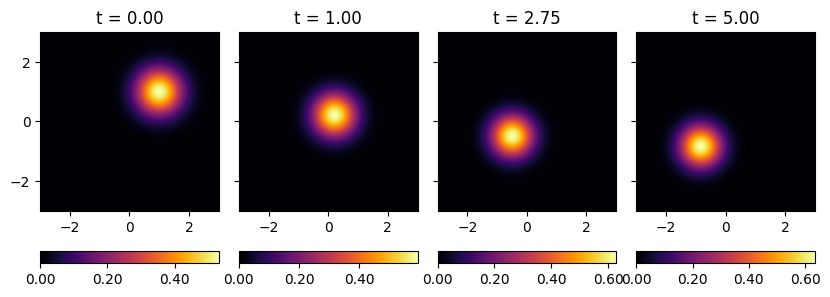

In [9]:
e_alpha_t = lambda t: jnp.array(
    [[jnp.exp(-alpha[0] * t), 0], [0, jnp.exp(-alpha[1] * t)]]
)
M_t = lambda t: mu - mu @ e_alpha_t(t) + e_alpha_t(t) @ mu_0
Sigma_t = lambda t: (
    jnp.array([[1 / 4 * (1 - jnp.exp(-t)), 0], [0, 1 / 4 * (1 - jnp.exp(-t))]])
    + e_alpha_t(t) @ cov_0 @ e_alpha_t(t).T
)


def u_marginal_true(t, x):
    t *= Tmax
    return (
        1
        / (2 * jnp.pi * jnp.sqrt(jnp.linalg.det(Sigma_t(t))))
        * (jnp.exp(-0.5 * (x - M_t(t)).T @ jnp.linalg.inv(Sigma_t(t)) @ (x - M_t(t))))
    )


times = [0, 0.2, 0.55, 1]  # in the unit time scale
u_marginal_true_ = lambda t_x: u_marginal_true(t_x[0], t_x[1:3])
jinns.plot.plot2d(
    fun=u_marginal_true_,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10 * len(times)),
)

In [10]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params, eq_params={"sigma": sigma, "alpha": alpha, "mu": mu}
)

## Set up the initial condition
Define $u_0(x)$

In [11]:
# Another init
def u0(x):
    return multivariate_normal.pdf(x, mean=mu_0, cov=cov_0)


vectorized_u0 = vmap(u0, (0), 0)

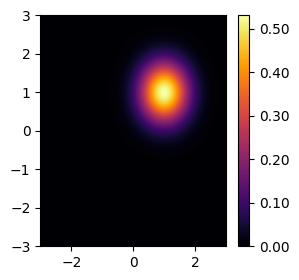

In [12]:
jinns.plot.plot2d(fun=u0, xy_data=val_xy_data, title="u0(x,y)", figsize=(3, 3))

## Loss construction

We decide to provide the set of points upon which the normalization constant will be computed

In [34]:
int_xmin, int_xmax = -3, 3
int_ymin, int_ymax = -3, 3

n_samples = int(1e3)
volume = (int_xmax - int_xmin) * (int_ymax - int_ymin)
norm_weights = jnp.array([volume])
key, subkey1, subkey2 = random.split(key, 3)
mc_samples = jnp.concatenate(
    [
        random.uniform(subkey1, shape=(n_samples, 1), minval=int_xmin, maxval=int_xmax),
        random.uniform(subkey2, shape=(n_samples, 1), minval=int_ymin, maxval=int_ymax),
    ],
    axis=-1,
)

In [14]:
OU_fpe_non_statio_2D_loss = jinns.loss.OU_FPENonStatioLoss2D(Tmax=Tmax)

In [15]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1,
    initial_condition=10,
    # norm_loss=0 # using this term is still a research area !!!
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_2D_loss,
    initial_condition_fun=u0,
    norm_weights=norm_weights,
    norm_samples=mc_samples,
    params=init_params,
)

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/loss/_LossPDE.py:181: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [16]:
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(init_params, batch=train_data.get_batch()[1])


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 1689.01
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '37.97', 'initial_condition': '13.64', 'norm_loss': '1637.41', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [17]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-3)

In [18]:
n_iter = 25000

In [19]:
params = init_params

In [20]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _ = jinns.solve(
    init_params=params, data=train_data, optimizer=tx, loss=loss, n_iter=n_iter
)


Compilation took
 4.464049816131592 

[train] Iteration 0: loss value = 1689.01171875
[train] Iteration 1000: loss value = 0.12188372761011124
[train] Iteration 2000: loss value = 0.1043970063328743
[train] Iteration 3000: loss value = 0.10051476210355759
[train] Iteration 4000: loss value = 0.09627614170312881
[train] Iteration 5000: loss value = 0.09221344441175461
[train] Iteration 6000: loss value = 0.08877911418676376
[train] Iteration 7000: loss value = 0.08626898378133774
[train] Iteration 8000: loss value = 0.08454912155866623
[train] Iteration 9000: loss value = 0.08317311108112335
[train] Iteration 10000: loss value = 0.0818880945444107
[train] Iteration 11000: loss value = 0.07961922883987427
[train] Iteration 12000: loss value = 0.05151290073990822
[train] Iteration 13000: loss value = 0.01515023224055767
[train] Iteration 14000: loss value = 0.0057503841817379
[train] Iteration 15000: loss value = 0.003031556261703372
[train] Iteration 16000: loss value = 0.00183714716695

## Results

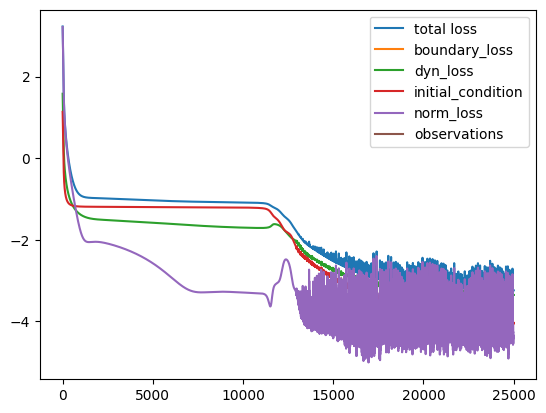

In [21]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.legend()
plt.show()

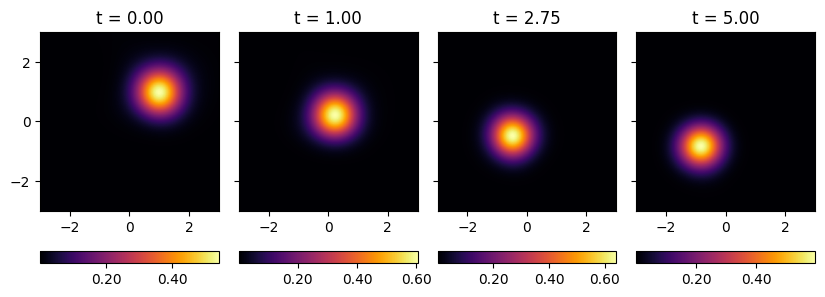

In [22]:
times = [0, 0.2, 0.55, 1]  # times in the unit time scale
u_est = lambda t_x: u(t_x, params.nn_params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    figsize=(10, 10 * len(times)),
)

**Error maps for PINN**

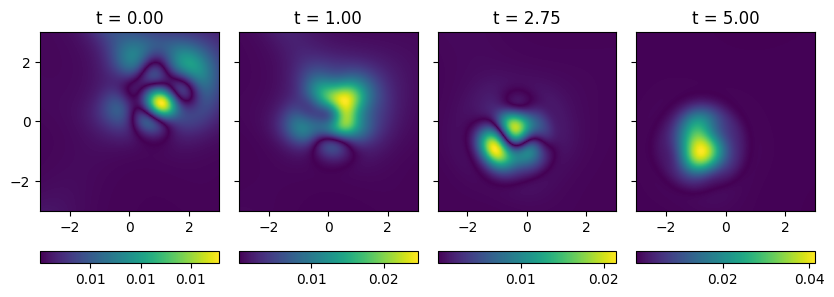

In [23]:
error_pinn = lambda t_x: jnp.abs(u_marginal_true_(t_x) - u_est(t_x))
jinns.plot.plot2d(
    fun=error_pinn,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    figsize=(10, 10 * len(times)),
    cmap="viridis",
)

## 2) Separable PINNs
In this section, we run experiments in the same context but with [Separable PINNs](https://openreview.net/pdf?id=dEySGIcDnI).

In [24]:
key = jax.random.PRNGKey(2)

In [25]:
d = 3
r = 256
eqx_list = (
    (eqx.nn.Linear, 1, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, r),
)
key, subkey = random.split(key)

In [26]:
u, init_nn_params = jinns.nn.SPINN_MLP.create(subkey, d, r, eqx_list, "nonstatio_PDE")

In [27]:
n = 5000
nb = None
ni = 200
xmin = -3
xmax = 3
ymin = -3
ymax = 3
tmin = 0
tmax = 1
method = "uniform"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=2,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    domain_batch_size=32,
    initial_batch_size=32,
    tmin=tmin,
    tmax=tmax,
    method=method,
)

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/data/_DataGenerators.py:943: UserWarning: Grid sampling is requested in dimension 2 with a non perfect square dataset size (self.ni = 200). Modifying self.ni to self.ni = 196.
  warnings.warn(


In [28]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params, eq_params={"sigma": sigma, "alpha": alpha, "mu": mu}
)

In [35]:
int_xmin, int_xmax = -3, 3
int_ymin, int_ymax = -3, 3

n_samples = 32
key, subkey1, subkey2 = random.split(key, 3)
mc_samples = jnp.concatenate(
    [
        random.uniform(subkey1, shape=(n_samples, 1), minval=int_xmin, maxval=int_xmax),
        random.uniform(subkey2, shape=(n_samples, 1), minval=int_ymin, maxval=int_ymax),
    ],
    axis=-1,
)

In [36]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1,
    initial_condition=10,
    # norm_loss=0 # using this term is still a research area !!!
)
OU_fpe_non_statio_2D_loss = jinns.loss.OU_FPENonStatioLoss2D(Tmax=Tmax)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_2D_loss,
    initial_condition_fun=u0,
    norm_weights=norm_weights,
    norm_samples=mc_samples,
    params=init_params,
)

In [37]:
params = init_params

In [38]:
import optax

tx = optax.adamw(learning_rate=1e-4)
n_iter = 50000
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _ = jinns.solve(
    init_params=params, data=train_data, optimizer=tx, loss=loss, n_iter=n_iter
)

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/utils/_utils.py:80: UserWarning: [Output of initial_condition_fun] Performing operation `-` between arrays of different shapes: got (32, 32) for the custom array and (32, 32, 1) for the PINN. This can cause unexpected and wrong broadcasting. Reshaping (32, 32) into (32, 32, 1). Reshape your custom array to math the expected_shape=(32, 32, 1) to prevent this warning.
  warnings.warn(
/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/utils/_utils.py:80: UserWarning: [Output of initial_condition_fun] Performing operation `-` between arrays of different shapes: got (32, 32) for the custom array and (32, 32, 1) for the PINN. This can cause unexpected and wrong broadcasting. Reshaping (32, 32) into (32, 32, 1). Reshape your custom array to math the expected_shape=(32, 32, 1) to prevent this warning.
  warnings.warn(



Compilation took
 11.466371774673462 

[train] Iteration 0: loss value = 0.7204273343086243
[train] Iteration 1000: loss value = 0.03727097436785698
[train] Iteration 2000: loss value = 0.029380343854427338
[train] Iteration 3000: loss value = 0.025833509862422943
[train] Iteration 4000: loss value = 0.02072140760719776
[train] Iteration 5000: loss value = 0.010690703056752682
[train] Iteration 6000: loss value = 0.006214292254298925
[train] Iteration 7000: loss value = 0.0094841830432415
[train] Iteration 8000: loss value = 0.005546628963202238
[train] Iteration 9000: loss value = 0.006928278133273125
[train] Iteration 10000: loss value = 0.007141662761569023
[train] Iteration 11000: loss value = 0.0047212038189172745
[train] Iteration 12000: loss value = 0.0036249891854822636
[train] Iteration 13000: loss value = 0.005318771582096815
[train] Iteration 14000: loss value = 0.003921223804354668
[train] Iteration 15000: loss value = 0.0041259052231907845
[train] Iteration 16000: loss va

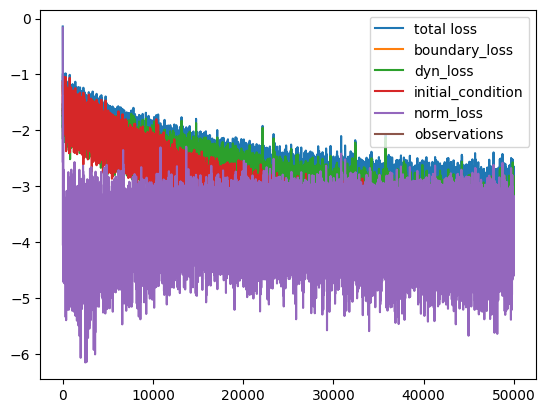

In [39]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.legend()
plt.show()

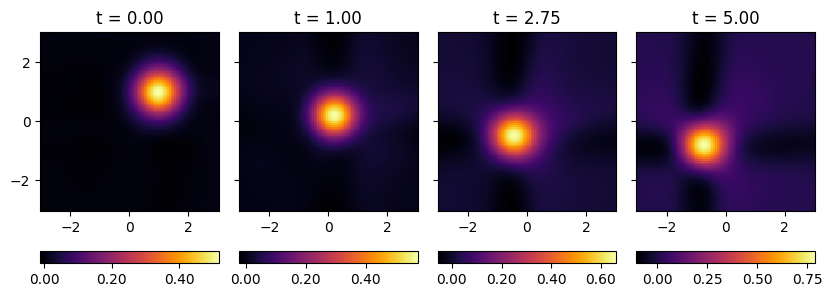

In [40]:
nx, ny = 100, 100  # Set less validation points for SPINN otherwise GPU memory explodes
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]


times = [0, 0.2, 0.55, 1]  # times in the rescaled time
u_est = lambda t_x: u(t_x, params.nn_params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10 * len(times)),
    spinn=True,
)

**Error maps for SPINN**

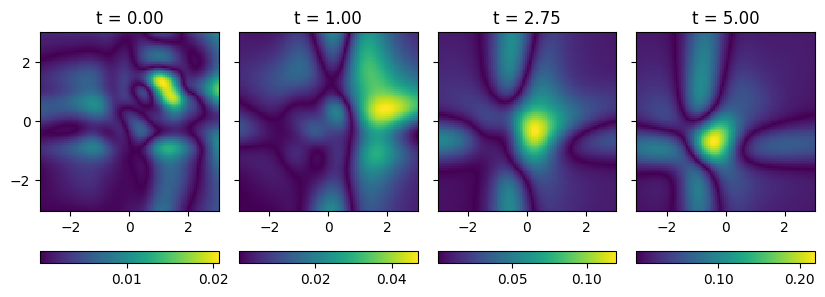

In [41]:
def u_marginal_true_spinn_(t_x):
    t_spinn = jinns.utils._utils.get_grid(t_x)[..., 0]
    x_spinn = jinns.utils._utils.get_grid(t_x)[..., 1:3]
    u_marginal_true_vmap = jax.vmap(
        jax.vmap(jax.vmap(u_marginal_true, (0, 0)), (0, 0)), (0, 0)
    )
    return u_marginal_true_vmap(t_spinn, x_spinn)


error_spinn = lambda t_x: jnp.abs(u_marginal_true_spinn_(t_x) - u_est(t_x).squeeze())

jinns.plot.plot2d(
    fun=error_spinn,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    figsize=(10, 10 * len(times)),
    spinn=True,
    cmap="viridis",
)